# Image Matching Challenge 2022

This notebook is based on the 2022 Kaggle Image Matching Challenge competition in 2022.
The goal is to match images that are of the same landmark.
https://www.kaggle.com/competitions/image-matching-challenge-2022/discussion

I will be developing my workflow based on the following recap. To summarize the recap,
the workflow consists of the following steps:
1. Use base matcher to find an initial pool of matches (LoFTR seems to works best).
2. Estimate co-visible area via clustering
3. Crop/resize visible co-visible areas
4. Use base matcher on (3) to extend the matching process
5. Filter correspondences using non-maxima-suppression (ANMS or radius-based NMS)
6. Find fundamental index with MAGSAC++
https://ducha-aiki.github.io/wide-baseline-stereo-blog/2022/07/05/IMC2022-Recap.html

In [1]:
# Only run once
# # Configure environment and grab LoFTR code.
# !git clone https://github.com/zju3dv/LoFTR --depth 1
# %cd LoFTR/
#
# # Download pretrained weights
# !mkdir weights
# %cd weights/
# !gdown --id 1w1Qhea3WLRMS81Vod_k5rxS_GNRgIi-O  # indoor-ds
# !gdown --id 1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY  # outdoor-ds
# %cd ../..

In [2]:
# import libraries
import math
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, patches
from matplotlib.patches import ConnectionPatch
from sklearn.cluster import DBSCAN

from LoFTR.src.utils.plotting import make_matching_figure
from LoFTR.src.loftr import LoFTR, default_cfg

from src.utils import get_matches_loftr, dbscan_crop

## Find Initial Pool via Base Matcher
This section will use LoFTR (Detector-Free Local Feature Matching with Transformers)
https://zju3dv.github.io/loftr/

Sample code can be found on colab here:
https://colab.research.google.com/drive/1BgNIOjFHauFoNB95LGesHBIjioX74USW?usp=sharing#scrollTo=mdJ-G1CiFUc3

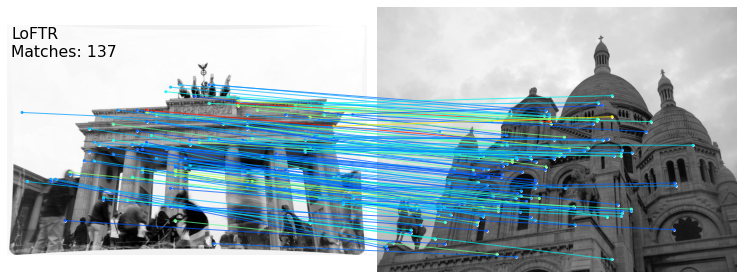

In [8]:
img0_pth = "data/train/brandenburg_gate/images/00883281_9633489441.jpg"
#img1_pth = "data/train/brandenburg_gate/images/01069771_8567470929.jpg" # high match
img1_pth = "data/train/sacre_coeur/images/00318781_8039756060.jpg"      # low match

# prep images
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)

stage1_res = get_matches_loftr(img0_raw, img1_raw, resolution=(600,800))
stage1_res['figure']

## Isolate Co-Visible Area
1. Cluster mkpts for image 0 and image 1 with DBSCAN
2. Determine threshold where both are > ~80%
3. Keep either pairs based on cluster0 or cluster1 (whichever has more)
4. Crop and scale

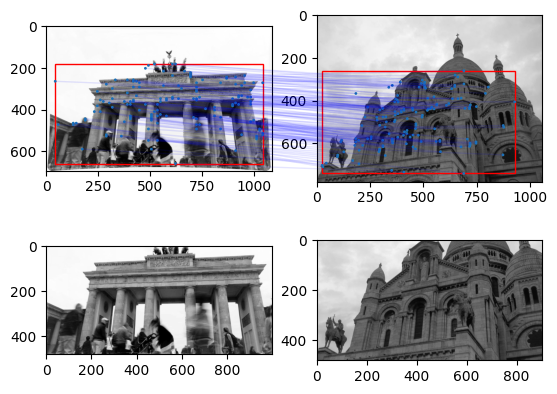

In [9]:
crop_res = dbscan_crop(stage1_res['img0'], stage1_res['img1'], stage1_res['mkpts0'], stage1_res['mkpts1'], min_samples=5, eps=30)
crop_res['figure']

## Rematch on Cropped Images
Rematch mkpts from the cropped image. Use a different resolution to get a diversity of points.

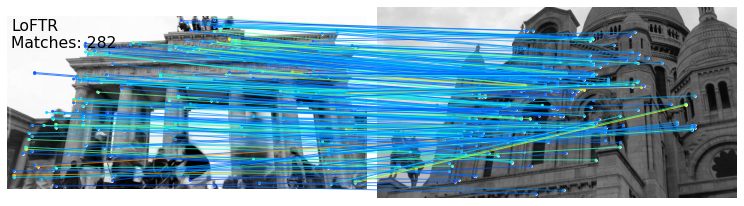

In [10]:
stage2_res = get_matches_loftr(crop_res['img0_crop'], crop_res['img1_crop'], resolution=(960, 1280))
stage2_res['figure']

## Find Fundamental Matrix
1. Concatenate the mkpts from stage 1 and stage 2
2. Use USAC_MAGSAC (variation of RANSAC) to find the fundamental matrix
3. Calculate the number of inlier points
4. Threshold to determine if images are of the same subject

In [11]:
mkpts0 = np.concatenate((stage1_res['mkpts0'], stage2_res['mkpts0']))
mkpts1 = np.concatenate((stage1_res['mkpts1'], stage2_res['mkpts1']))

In [12]:
# find fundamental matrix
F, msk = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.19, 0.99999, 50000)
# coverage of inliers
coverage = len(msk[msk==1])/len(msk)

print(f'Covarage: {coverage:0.2%}')

Covarage: 2.63%
